In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  device = "cuda:0"

Fri Nov 17 09:03:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import math
import warnings
import string
import unicodedata
from tqdm import tqdm

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 1000
pd.options.display.float_format = '{:.4f}'.format
pd.options.mode.chained_assignment = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Project_Work_Cefriel/Dataset_Text_Variable_Clean/Dataset_XLM_RoBERTa_Model.csv')

In [ ]:
!pip install transformers -q # Il -q serve per non mostrare tutti i download dei pacchetti ogni volta
!pip install sentencepiece -q # Il -q serve per non mostrare tutti i download dei pacchetti ogni volta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.2 MB/s eta 0:00:00


In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

(…)ase/resolve/main/sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

(…)lm-roberta-base/resolve/main/config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=7)
model.to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [ ]:
# Preprocess and tokenize your text data
# Encode text and labels
encoded_data = tokenizer.batch_encode_plus(df["Descrizione_Bene_Pre_Process"],
                                           truncation=True,
                                           padding='max_length',
                                           max_length=512,
                                           return_tensors='pt',
                                           return_attention_mask=True)

input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']
labels = torch.tensor(df["Destinazione_Uso_Encoded"])

In [ ]:
batch_size = 8
learning_rate = 1e-5
epochs = 2

# Initialize optimizer and loss function
optimizer = AdamW(model.parameters(), lr= learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# Initialize lists to store metrics for each fold
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

# Initialize lists to store predictions and true labels for overall classification report
overall_predictions = []
overall_true_labels = []

# Stratified K-Fold Cross-Validation
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
for train_index, val_index in folds.split(input_ids, labels):
    train_input_ids, train_attention_mask, train_labels = input_ids[train_index], attention_mask[train_index], labels[train_index]
    val_input_ids, val_attention_mask, val_labels = input_ids[val_index], attention_mask[val_index], labels[val_index]

    # Create data loaders
    train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
      model.train()  # Set the model in training mode
      for batch in tqdm(train_loader):
        inputs, masks, targets = batch
        inputs = inputs.to(device)
        masks = masks.to(device)
        targets = targets.to(device)
        outputs = model(input_ids=inputs, attention_mask=masks)
        loss = loss_fn(outputs.logits, targets)
        loss.backward()  # Backpropagation
        optimizer.step()
        optimizer.zero_grad()
    break
torch.save(model.state_dict(),"model.pth")

# Evaluation on the validation set for this fold
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in val_loader:
        inputs, masks, targets = batch
        inputs = inputs.to(device)
        masks = masks.to(device)
        targets = targets.to(device)
        outputs = model(input_ids=inputs, attention_mask=masks)
        predicted = torch.argmax(outputs.logits, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(predicted.tolist())

    # Store predictions and true labels for the overall classification report
    overall_predictions.extend(y_pred)
    overall_true_labels.extend(y_true)

    # Calculate and store metrics for this fold
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate the overall metrics
overall_accuracy = sum(accuracy_scores) / len(accuracy_scores)
overall_precision = sum(precision_scores) / len(precision_scores)
overall_recall = sum(recall_scores) / len(recall_scores)
overall_f1_score = sum(f1_scores) / len(f1_scores)

# Generate the overall classification report
overall_classification_rep = classification_report(overall_true_labels,
                                                   overall_predictions,
                                                   target_names=['Agricultural Building: 0',
                                                                 'Hotel: 1',
                                                                 'Industrial: 2',
                                                                 'Land: 3',
                                                                 'Residential: 4',
                                                                 'Retail: 5',
                                                                 'Storage: 6'])

print(f"Overall Classification Report:\n{overall_classification_rep}")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1-Score: {overall_f1_score}")

100%|██████████| 16601/16601 [3:42:29<00:00,  1.24it/s]


Overall Classification Report:
                          precision    recall  f1-score   support

Agricultural Building: 0       0.00      0.00      0.00       110
                Hotel: 1       0.71      0.71      0.71       112
           Industrial: 2       0.62      0.54      0.58       454
                 Land: 3       0.82      0.83      0.82      1160
          Residential: 4       0.93      0.97      0.95     26436
               Retail: 5       0.78      0.76      0.77      1549
              Storage: 6       0.77      0.54      0.63      3380

                accuracy                           0.90     33201
               macro avg       0.66      0.62      0.64     33201
            weighted avg       0.89      0.90      0.90     33201

Overall Accuracy: 0.9026234149573809
Overall Precision: 0.6614678137951703
Overall Recall: 0.6208433247392404
Overall F1-Score: 0.6377996447667851


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

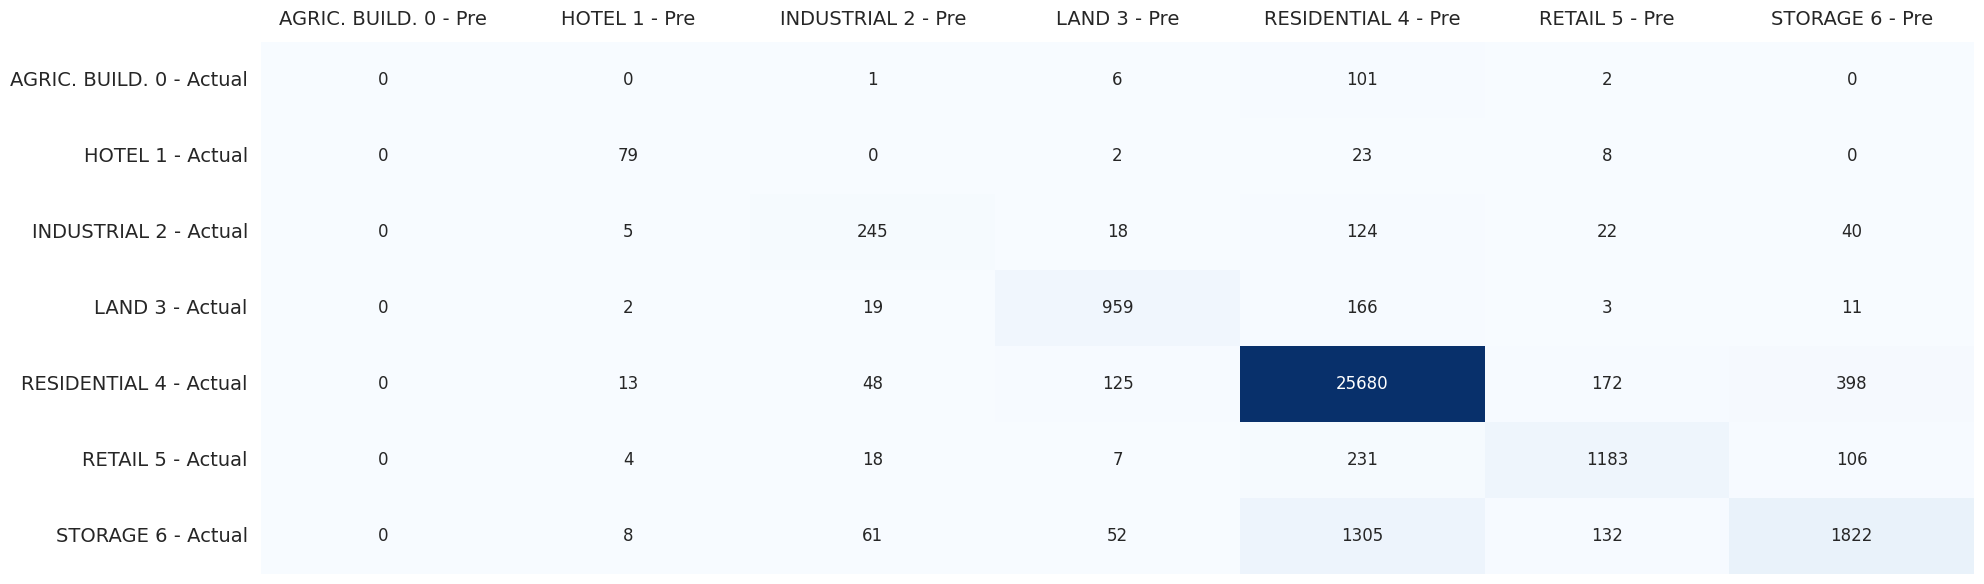

In [ ]:
cm_pred = confusion_matrix(overall_true_labels, overall_predictions)

cm_pred = pd.DataFrame(cm_pred,
                       index=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                       columns = ['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'])

# Mostro la confusion matrix su una heatmap:
sns.set(rc={'figure.figsize':(20,6)})
heatmap = sns.heatmap(cm_pred,
            annot=True,
            cmap="Blues",
            fmt="d",
            xticklabels=['AGRIC. BUILD. 0 - Pre','HOTEL 1 - Pre','INDUSTRIAL 2 - Pre','LAND 3 - Pre','RESIDENTIAL 4 - Pre','RETAIL 5 - Pre','STORAGE 6 - Pre'],
            yticklabels=['AGRIC. BUILD. 0 - Actual','HOTEL 1 - Actual','INDUSTRIAL 2 - Actual','LAND 3 - Actual','RESIDENTIAL 4 - Actual','RETAIL 5 - Actual','STORAGE 6 - Actual'],
                     cbar=False)

heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)

plt.tick_params(axis='x', labeltop=True, labelbottom=False)
plt.tight_layout()
plt.show()

In [1]:
print("Numero predizioni corrette: ", 79+245+959+25680+1183+1822)
print("Numero predizioni sbagliate: ", 33201-(79+245+959+25680+1183+1822))

Numero predizioni corrette:  29968
Numero predizioni sbagliate:  3233
